# **EPIC 4 - MODELING**

![modeling](../docs/images/modeling.png)

## Objectives

- Train and validate the model on the prepared image datasets.

### Acceptance Criteria
- Image sets should initially be 70% training, 15% validation, and 15% test.
- Model performs 'well' on validation set - otherwise, return to Pre-process images #4

## Tasks
- Split the images into training, validation, and test sets.
- Plot the numbers of images in each set (LO 3.1).

## Inputs

- inputs/[datasets]: folders containing the prepare image datasets for each animal.

## Outputs

- Image datasets for each animal split into training, validation, and test sets.

---

# Import packages

In [4]:
import os
import joblib
import pandas as pd
import PIL
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Set working directory

In [85]:
current_dir = os.getcwd()
print("Current working directory is:", current_dir)

Current working directory is: /Users/gingermale/Documents/repos/PP5/pet-image-classifier


**If required**, run following cell to move to the parent / project root directory.

In [6]:
os.chdir(os.path.dirname(current_dir)) # Change the current working directory to the parent directory
current_dir = os.getcwd() # Get the new current working directory
print("Changing the working directory to parent folder:", current_dir)

Changing the working directory to parent folder: /Users/gingermale/Documents/repos/PP5/pet-image-classifier


# Set input and output paths

In [7]:
data_dir = current_dir + '/dataset'
inputs_dir = current_dir + '/inputs'
train_dir = inputs_dir + '/train'
validate_dir = inputs_dir + '/validate'
test_dir = inputs_dir + '/test'

version = 'v4'
outputs = f'outputs/{version}'

if os.path.exists(outputs):
    print(f'Output directory for {version} already exists.')
else:
    os.makedirs(outputs)
    print(f'New output directory for {version} created.')

Output directory for v4 already exists.


# Split the images

First, we define the function to split the images into training, validation, and test sets.

In [7]:
import shutil
import random
import joblib

def split_train_validate_test_images(data_dir, train_set_ratio, validate_set_ratio, test_set_ratio):
    """
    split data set into three groups by ratios specified
    """
    if train_set_ratio + validate_set_ratio + test_set_ratio != 1.0:
        print("train_set_ratio + validate_set_ratio + test_set_ratio should sum to 1.0")
        return

    # gets classes labels
    labels = os.listdir(data_dir)  # it should get only the folder name
    labels = [label for label in labels if label != '.DS_Store']  # Ignore .DS_Store files

    if 'test' in labels:
        pass
    else:
        # create train, test folders with classes labels sub-folder
        for folder in ['train', 'validate', 'test']:
            for label in labels:
                if folder == 'train':
                    os.makedirs(name=train_dir + '/' + label, exist_ok=True)
                elif folder == 'validate':
                    os.makedirs(name=validate_dir + '/' + label, exist_ok=True)
                else:  # folder == 'test'
                    os.makedirs(name=test_dir + '/' + label, exist_ok=True)

        for label in labels:

            files = os.listdir(data_dir + '/' + label)
            random.shuffle(files)

            train_set_files_qty = int(len(files) * train_set_ratio)
            validate_set_files_qty = int(len(files) * validate_set_ratio)

            # Move files to appropriate set directories
            # Use of enumerate leads to improved memory efficiency and faster execution time,
            # particularly in cases where the loop is iterating over a large number of items.
            for count, file_name in enumerate(files):
                if count < train_set_files_qty:
                    # move a given file to the train set
                    shutil.move(data_dir + '/' + label + '/' + file_name,
                                train_dir + '/' + label + '/' + file_name)

                elif count < (train_set_files_qty + validate_set_files_qty):
                    # move a given file to the validation set
                    shutil.move(data_dir + '/' + label + '/' + file_name,
                                validate_dir + '/' + label + '/' + file_name)

                else:
                    # move given file to test set
                    shutil.move(data_dir + '/' + label + '/' + file_name,
                                test_dir + '/' + label + '/' + file_name)

            os.rmdir(data_dir + '/' + label)

Then we run the function, specifying the ratios by which to split the images. We use 70% for training, 15% for validation, and 15% for testing as a reasonable starting point.

In [8]:
split_train_validate_test_images(data_dir,
                        train_set_ratio = 0.7,
                        validate_set_ratio=0.15,
                        test_set_ratio=0.15
                        )

# Number of images in each set (LO 3.1)

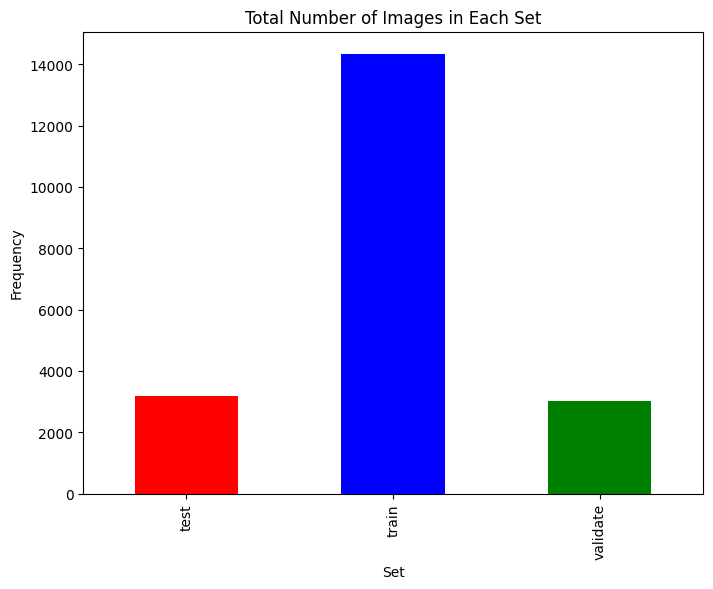

In [9]:
df_freq = pd.DataFrame(columns=['Set', 'Label', 'Frequency'])

# Define directories
directories = {
    'train': train_dir,
    'validate': validate_dir,
    'test': test_dir
}

for folder, dir_path in directories.items():
    labels_dir = [f for f in os.listdir(dir_path) if not f.startswith('.')]
    for label in labels_dir:
        files = [f for f in os.listdir(os.path.join(dir_path, label)) if not f.startswith('.')]
        count = len(files)
        df_to_append = pd.DataFrame([{'Set': folder, 'Label': label, 'Frequency': count}], columns=['Set', 'Label', 'Frequency'])
        df_freq = pd.concat([df_freq, df_to_append], ignore_index=True)

# Summarize data
df_summary = df_freq.groupby('Set')['Frequency'].sum().reset_index()

# Plotting
df_summary.plot(x='Set', y='Frequency', kind='bar', legend=False, color=['red', 'blue', 'green'], figsize=(8, 6))
plt.ylabel('Frequency')
plt.title('Total Number of Images in Each Set')
plt.show()

In [10]:
# Initialize an empty DataFrame
df_freq = pd.DataFrame(columns=['Label', 'Train', 'Validate', 'Test'])

# Define directories
directories = {
    'Train': train_dir,
    'Validate': validate_dir,
    'Test': test_dir
}

# Get list of all labels
labels = [f for f in os.listdir(train_dir) if not f.startswith('.')]

# For each label, count the number of images in each set
for label in labels:
    row = {'Label': label}
    for set_name, dir_path in directories.items():
        files = [f for f in os.listdir(os.path.join(dir_path, label)) if not f.startswith('.')]
        row[set_name] = len(files)
    df_to_append = pd.DataFrame([row], columns=['Label', 'Train', 'Validate', 'Test'])
    df_freq = pd.concat([df_freq, df_to_append], ignore_index=True)

print(df_freq)

                           Label Train Validate Test
0             Australian_terrier   137       29   30
1                     toy_poodle   105       22   24
2                 Great_Pyrenees   149       31   33
3                    Maltese_dog   176       37   39
4                Norwich_terrier   129       27   29
..                           ...   ...      ...  ...
115                      redbone   103       22   23
116                Gordon_setter   107       22   24
117             English_foxhound   109       23   25
118  German_short-haired_pointer   106       22   24
119   Greater_Swiss_Mountain_dog   117       25   26

[120 rows x 4 columns]


---

# Augment Images

In [86]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Initialize ImageDataGenerator

In [87]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                   width_shift_range=0.10, 
                                   height_shift_range=0.10,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   fill_mode='nearest',
                                   rescale=1./255
                              )

Augment training images

In [88]:
import pickle

batch_size = 20 # Set batch size

with open(f'outputs/{version}/image_shape.pkl', 'rb') as f:
        image_size = pickle.load(f)[:2]  # We only need the width and height

train_set = augmented_image_data.flow_from_directory(train_dir,
                                              target_size=image_size,
                                              color_mode='rgb',
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=True
                                              )

train_set.class_indices

Found 14355 images belonging to 121 classes.


{'.DS_Store': 0,
 'Afghan_hound': 1,
 'African_hunting_dog': 2,
 'Airedale': 3,
 'American_Staffordshire_terrier': 4,
 'Appenzeller': 5,
 'Australian_terrier': 6,
 'Bedlington_terrier': 7,
 'Bernese_mountain_dog': 8,
 'Blenheim_spaniel': 9,
 'Border_collie': 10,
 'Border_terrier': 11,
 'Boston_bull': 12,
 'Bouvier_des_Flandres': 13,
 'Brabancon_griffon': 14,
 'Brittany_spaniel': 15,
 'Cardigan': 16,
 'Chesapeake_Bay_retriever': 17,
 'Chihuahua': 18,
 'Dandie_Dinmont': 19,
 'Doberman': 20,
 'English_foxhound': 21,
 'English_setter': 22,
 'English_springer': 23,
 'EntleBucher': 24,
 'Eskimo_dog': 25,
 'French_bulldog': 26,
 'German_shepherd': 27,
 'German_short-haired_pointer': 28,
 'Gordon_setter': 29,
 'Great_Dane': 30,
 'Great_Pyrenees': 31,
 'Greater_Swiss_Mountain_dog': 32,
 'Ibizan_hound': 33,
 'Irish_setter': 34,
 'Irish_terrier': 35,
 'Irish_water_spaniel': 36,
 'Irish_wolfhound': 37,
 'Italian_greyhound': 38,
 'Japanese_spaniel': 39,
 'Kerry_blue_terrier': 40,
 'Labrador_retriev

Augment validation images

In [89]:
validate_augmented = ImageDataGenerator(rescale=1./255)
validate_set = validate_augmented.flow_from_directory(validate_dir,
                                              target_size=image_size,
                                              color_mode='rgb',
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=True
                                              )

validate_set.class_indices


Found 3025 images belonging to 121 classes.


{'.DS_Store': 0,
 'Afghan_hound': 1,
 'African_hunting_dog': 2,
 'Airedale': 3,
 'American_Staffordshire_terrier': 4,
 'Appenzeller': 5,
 'Australian_terrier': 6,
 'Bedlington_terrier': 7,
 'Bernese_mountain_dog': 8,
 'Blenheim_spaniel': 9,
 'Border_collie': 10,
 'Border_terrier': 11,
 'Boston_bull': 12,
 'Bouvier_des_Flandres': 13,
 'Brabancon_griffon': 14,
 'Brittany_spaniel': 15,
 'Cardigan': 16,
 'Chesapeake_Bay_retriever': 17,
 'Chihuahua': 18,
 'Dandie_Dinmont': 19,
 'Doberman': 20,
 'English_foxhound': 21,
 'English_setter': 22,
 'English_springer': 23,
 'EntleBucher': 24,
 'Eskimo_dog': 25,
 'French_bulldog': 26,
 'German_shepherd': 27,
 'German_short-haired_pointer': 28,
 'Gordon_setter': 29,
 'Great_Dane': 30,
 'Great_Pyrenees': 31,
 'Greater_Swiss_Mountain_dog': 32,
 'Ibizan_hound': 33,
 'Irish_setter': 34,
 'Irish_terrier': 35,
 'Irish_water_spaniel': 36,
 'Irish_wolfhound': 37,
 'Italian_greyhound': 38,
 'Japanese_spaniel': 39,
 'Kerry_blue_terrier': 40,
 'Labrador_retriev

Augment test images

In [90]:
test_augmented = ImageDataGenerator(rescale=1./255)
test_set = test_augmented.flow_from_directory(test_dir,
                                              target_size=image_size,
                                              color_mode='rgb',
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=True
                                              )

test_set.class_indices

Found 3200 images belonging to 121 classes.


{'.DS_Store': 0,
 'Afghan_hound': 1,
 'African_hunting_dog': 2,
 'Airedale': 3,
 'American_Staffordshire_terrier': 4,
 'Appenzeller': 5,
 'Australian_terrier': 6,
 'Bedlington_terrier': 7,
 'Bernese_mountain_dog': 8,
 'Blenheim_spaniel': 9,
 'Border_collie': 10,
 'Border_terrier': 11,
 'Boston_bull': 12,
 'Bouvier_des_Flandres': 13,
 'Brabancon_griffon': 14,
 'Brittany_spaniel': 15,
 'Cardigan': 16,
 'Chesapeake_Bay_retriever': 17,
 'Chihuahua': 18,
 'Dandie_Dinmont': 19,
 'Doberman': 20,
 'English_foxhound': 21,
 'English_setter': 22,
 'English_springer': 23,
 'EntleBucher': 24,
 'Eskimo_dog': 25,
 'French_bulldog': 26,
 'German_shepherd': 27,
 'German_short-haired_pointer': 28,
 'Gordon_setter': 29,
 'Great_Dane': 30,
 'Great_Pyrenees': 31,
 'Greater_Swiss_Mountain_dog': 32,
 'Ibizan_hound': 33,
 'Irish_setter': 34,
 'Irish_terrier': 35,
 'Irish_water_spaniel': 36,
 'Irish_wolfhound': 37,
 'Italian_greyhound': 38,
 'Japanese_spaniel': 39,
 'Kerry_blue_terrier': 40,
 'Labrador_retriev

Plot augmented images from training set:

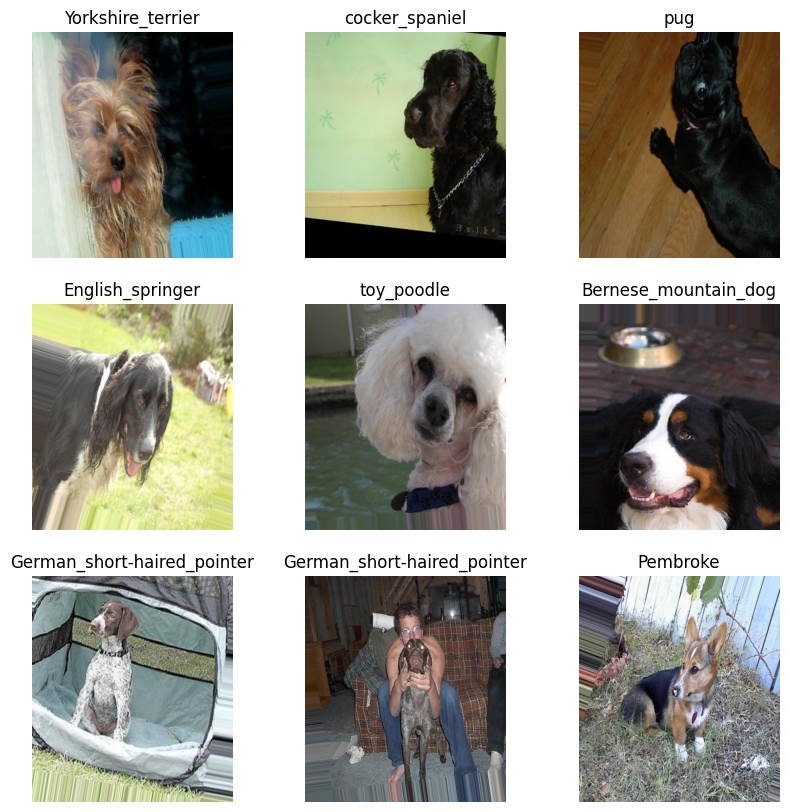

In [91]:
import matplotlib.pyplot as plt
import numpy as np

# Get class names
class_names = list(train_set.class_indices.keys())

plt.figure(figsize=(10, 10))
for i in range(9):
    img, label = next(train_set)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(img[0])
    label_index = np.argmax(label[0])
    plt.title(class_names[label_index])
    plt.axis("off")
plt.show()

Save class indices

In [55]:
joblib.dump(value=train_set.class_indices ,
            filename=f"{outputs}/class_indices.pkl")

['outputs/v4/class_indices.pkl']

# Train the Model

Import modeling packages

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Input, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization
# from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

In [92]:
num_classes = train_set.num_classes
num_classes

with open(f'outputs/{version}/image_shape.pkl', 'rb') as f:
    image_shape = pickle.load(f)
image_shape

(440, 390, 3)

Define the model using `create_model` function using standard architecture

In [93]:
def create_model():

    model = Sequential([
        Input(shape=image_shape),
        Conv2D(filters=32, kernel_size=(3, 3)), # removed padding = 'valid' from each layer
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(filters=64, kernel_size=(3, 3)), # removed kernel_regularizer=l2(0.00005)
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        # Conv2D(filters=128, kernel_size=(3, 3)), # removed kernel_regularizer=l2(0.00005)
        # Activation('relu'),
        # MaxPooling2D(pool_size=(2, 2)),
        # BatchNormalization(),
        
        Flatten(),
        Dense(units=128, activation='relu'),
        
        Dropout(0.5),
        Dense(num_classes, activation='softmax') # changed output from 1 to num_classes and activattion from sigmoid to softmax for multi-class
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy']) # changed loss from binary_crossentropy to categorical_crossentropy
    
    return model

In [71]:
create_model().summary()

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_47 (Conv2D)              │ (None, 438, 388, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_47 (Activation)      │ (None, 438, 388, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_47 (MaxPooling2D) │ (None, 219, 194, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_47          │ (None, 219, 194, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_48 (Conv2D)              │ (None, 217, 192, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_48 (Activation)      │ (None, 217, 192, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_48 (MaxPooling2D) │ (None, 108, 96, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_48          │ (None, 108, 96, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_19 (Flatten)            │ (None, 663552)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 128)            │    84,934,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 121)            │        15,609 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,970,169 (324.14 MB)

 Trainable params: 84,969,977 (324.13 MB)

 Non-trainable params: 192 (768.00 B)

Early stopping

In [94]:
early_stop = EarlyStopping(monitor='val_loss',patience=5)

Fit model for training

In [95]:
model = create_model()

model.fit(train_set,
          epochs=10,
          steps_per_epoch = len(train_set.classes) // batch_size,
          validation_data=validate_set,
          callbacks=[early_stop],
          verbose=1
          )

Epoch 1/10
717/717 ━━━━━━━━━━━━━━━━━━━━ 3101s 4s/step - accuracy: 0.0095 - loss: 82.6159 - val_accuracy: 0.0119 - val_loss: 4.8264
Epoch 2/10
  1/717 ━━━━━━━━━━━━━━━━━━━━ 21:14 2s/step - accuracy: 0.0000e+00 - loss: 4.7996

2024-06-16 16:39:57.011741: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/homebrew/Cellar/python@3.12/3.12.3/Frameworks/Python.framework/Versions/3.12/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


717/717 ━━━━━━━━━━━━━━━━━━━━ 38s 50ms/step - accuracy: 0.0000e+00 - loss: 4.7996 - val_accuracy: 0.0119 - val_loss: 4.8208
Epoch 3/10
717/717 ━━━━━━━━━━━━━━━━━━━━ 4278s 6s/step - accuracy: 0.0132 - loss: 4.8395 - val_accuracy: 0.0116 - val_loss: 4.8572
Epoch 4/10
  1/717 ━━━━━━━━━━━━━━━━━━━━ 22:56 2s/step - accuracy: 0.0500 - loss: 4.7885

2024-06-16 17:51:53.068817: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


717/717 ━━━━━━━━━━━━━━━━━━━━ 38s 50ms/step - accuracy: 0.0500 - loss: 4.7885 - val_accuracy: 0.0116 - val_loss: 4.8565
Epoch 5/10
717/717 ━━━━━━━━━━━━━━━━━━━━ 1584s 2s/step - accuracy: 0.0103 - loss: 4.8641 - val_accuracy: 0.0063 - val_loss: 312.0392
Epoch 6/10
  1/717 ━━━━━━━━━━━━━━━━━━━━ 24:29 2s/step - accuracy: 0.0000e+00 - loss: 4.7813

2024-06-16 18:18:55.576827: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


717/717 ━━━━━━━━━━━━━━━━━━━━ 50s 67ms/step - accuracy: 0.0000e+00 - loss: 4.7813 - val_accuracy: 0.0063 - val_loss: 328.1798
Epoch 7/10
717/717 ━━━━━━━━━━━━━━━━━━━━ 1611s 2s/step - accuracy: 0.0118 - loss: 4.8321 - val_accuracy: 0.0119 - val_loss: 4.7881
Epoch 8/10
  1/717 ━━━━━━━━━━━━━━━━━━━━ 22:48 2s/step - accuracy: 0.0000e+00 - loss: 4.8224

2024-06-16 18:46:36.183234: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


717/717 ━━━━━━━━━━━━━━━━━━━━ 46s 62ms/step - accuracy: 0.0000e+00 - loss: 4.8224 - val_accuracy: 0.0119 - val_loss: 4.7883
Epoch 9/10
717/717 ━━━━━━━━━━━━━━━━━━━━ 1565s 2s/step - accuracy: 0.0109 - loss: 4.7835 - val_accuracy: 0.0119 - val_loss: 4.7825
Epoch 10/10
  1/717 ━━━━━━━━━━━━━━━━━━━━ 21:34 2s/step - accuracy: 0.0000e+00 - loss: 4.8017

2024-06-16 19:13:26.804381: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


717/717 ━━━━━━━━━━━━━━━━━━━━ 45s 60ms/step - accuracy: 0.0000e+00 - loss: 4.8017 - val_accuracy: 0.0119 - val_loss: 4.7826


Save model

In [99]:
model.save(f'outputs/{version}/pet-image-classifier.h5')

In [105]:
# Assuming `test_set` is your test data
loss, accuracy = model.evaluate(test_set)

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

/Users/gingermale/Documents/repos/PP5/pet-image-classifier/venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


160/160 ━━━━━━━━━━━━━━━━━━━━ 40s 246ms/step - accuracy: 0.0108 - loss: 4.7841
Test Loss: 4.781753063201904
Test Accuracy: 0.012187499552965164


# Model Performance

Load model

In [100]:
from keras.models import load_model

# Specify the version if it's a variable in your code
version = 'v4'

# Load the model
model = load_model(f'outputs/{version}/pet-image-classifier.h5')
model.summary()

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_53 (Conv2D)              │ (None, 438, 388, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_53 (Activation)      │ (None, 438, 388, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_53 (MaxPooling2D) │ (None, 219, 194, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_53          │ (None, 219, 194, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_54 (Conv2D)              │ (None, 217, 192, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_54 (Activation)      │ (None, 217, 192, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_54 (MaxPooling2D) │ (None, 108, 96, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_54          │ (None, 108, 96, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_22 (Flatten)            │ (None, 663552)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 128)            │    84,934,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 121)            │        15,609 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,970,171 (324.14 MB)

 Trainable params: 84,969,977 (324.13 MB)

 Non-trainable params: 192 (768.00 B)

 Optimizer params: 2 (12.00 B)

Model learning curve

In [104]:
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss','val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{outputs}/model_training_losses.png', bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy','val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{outputs}/model_training_acc.png', bbox_inches='tight', dpi=150)
plt.show()

AttributeError: 'Sequential' object has no attribute 'history'

Model evaluation

In [129]:
from keras.models import load_model
model = load_model('outputs/v2/pet-image-classifier.h5')
model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])

In [130]:
evaluation = model.evaluate(test_set)

 1/18 ━━━━━━━━━━━━━━━━━━━━ 6s 375ms/step - accuracy: 0.0000e+00 - loss: 4.2908

/Users/gingermale/Documents/repos/PP5/pet-image-classifier/venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - accuracy: 0.0172 - loss: 4.2752


Save evaluation metrics

In [131]:
joblib.dump(value=evaluation ,
            filename=f"outputs/v2/evaluation.pkl")

['outputs/v2/evaluation.pkl']

Predict on new data

Image shape: (150, 150), Image mode: RGB


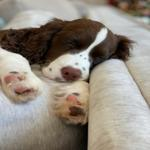

In [134]:
from tensorflow.keras.preprocessing import image

pointer = 2 
label = labels[2] # select animal index

pil_image = image.load_img(test_dir + '/'+ label + '/'+ os.listdir(test_dir+'/'+ label)[pointer],
                          target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

Convert image to array for prediction

In [135]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 150, 150, 3)


Make prediction

In [136]:
pred_proba = model.predict(my_image)[0,0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class =  target_map[pred_proba > 0.5]  

if pred_class == target_map[0]: pred_proba = 1 - pred_proba

print(pred_proba)
print(pred_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
0.9866433311253786
Abyssinian
